# Analisi Esplorativa dei Dati: civili uccisi dalla Polizia in USA
L'obbiettivo che ci poniamo è quello di analizzare alcuni aspetti demografici, sociali ed economici della popolazione degli Stati Uniti d'America in relazione con episodi di omicidi commessi dalla Polizia americana ai danni dei civili.
Terremo conto delle diverse razze qualora dovessero essere presenti condizionamenti raziali.
Per l'analisi in questione ci serviremo di alcuni dataset prelevati dal famoso sito Kaggle, dal Washington Post e altre fonti che vedremo in seguito.

* [Importo librerie e carico i dati](#chapter1)
* [Creazione tabelle utili all'analisi](#chapter2)
* [Analisi](#chapter3)
    * [1. Analisi demografica popolazione, tasso di povertà e completamento High School](#section_3_1)
    * [2. Analisi uccisioni da parte della Polizia ai danni dei civili, moventi ed età delle vittime](#section_3_2)
    * [3. Rilevamento eventuale presenza di forme di razzismo nei casi di omicio da parte della Polizia](#section_3_3)
    * [4. Analisi sociale, fattori che potrebbero incidere sul tasso di uccisioni da parte della Polizia Americana](#section_3_4)
* [Conclusioni](#chapter4)

## Importo librerie e carico i dati <a class="anchor" id="chapter1"></a>

In [1]:
#Librerie necessarie

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from functools import reduce
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()
%matplotlib inline

#Modulo necessario per generare mappa plotly

import sys
!{sys.executable} -m pip install plotly==4.14.3

Analisi natura dei dati:

- fatal-police-shootings-data.csv : dataset redatto dal Washington Post contenente tutte le uccisioni per mano della polizia dal 2015 ad oggi.
- ShareRaceByCity.csv : dataset sulla distribuzione delle razze per città (2015/2016)
- MedianHouseholdIncome2015.csv : dataset sulla povertà e sul reddito medio delle famiglie per città (2015/2016)
- PercentOver25CompletedHighSchool.csv : dataset sulla percentuale di persone maggiori di 25 anni con almeno un titolo di scuola superiore (2015/2016)
- PercentagePeopleBelowPovertyLevel.csv : dataset sul livello di povertà per città (2015/2016)
- PopulationByCity.csv : dataset distribuzione popolazione per città

In [2]:
#Csv importati

kill=pd.read_csv('fatal-police-shootings-data.csv')
#fonte https://github.com/washingtonpost/data-police-shootings

population_by_city=pd.read_csv('PopulationByCity.csv')
#fornita dall'esercitatore 

race_city=pd.read_csv('ShareRaceByCity.csv').dropna()
#fonte https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us
med_house_income=pd.read_csv('MedianHouseholdIncome2015.csv', encoding = 'unicode_escape').dropna()
#fonte https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us
hs25=pd.read_csv('PercentOver25CompletedHighSchool.csv', encoding = 'unicode_escape').dropna()
#fonte https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us
ppp=pd.read_csv('PercentagePeopleBelowPovertyLevel.csv', encoding = 'unicode_escape').dropna()
#fonte https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us

## Creazione tabelle utili all'analisi <a class="anchor" id="chapter2"></a>

Quello che vogliamo fare è riassumete tutti i dataset i due tabelle principali.
La prima è composta dai dataset riguardanti la popolazione, il tasso di povertà e il reddito medio per città.

In [3]:
#Rinomino alcune colonne

hs25.rename(columns={"Geographic Area": "state", "City": "city"}, inplace=True)
ppp.rename(columns={"Geographic Area": "state", "City": "city"}, inplace=True)
race_city.rename(columns={"Geographic area": "state", "City": "city"}, inplace=True)
med_house_income.rename(columns={"Geographic Area": "state", "City": "city", "Median Income": "median_income"}, inplace=True)

#Ripulisco e gestisco i record

population_by_city.dropna()
drop_zero=population_by_city.index[population_by_city["population"] == 0].tolist()
population_by_city=population_by_city.drop(population_by_city.index[drop_zero])
med_house_income['median_income'] = med_house_income['median_income'].replace({'(X)':np.nan,'-':np.nan})
med_house_income=med_house_income.fillna(0)

# Raggruppo per stato e città e conto i casi
cases = kill.groupby(['state','city']).count()['id'].reset_index()
cases.columns=['state','city','cases']

#Unisco le tabelle riguardanti la popolazione, le entrate per famiglia e il livello di studio
dfs = [ppp,med_house_income,hs25]
info = reduce(lambda left,right: pd.merge(left,right), dfs)

# Rinomino le colonne e rendo compatibili i nomi delle città con i DataFrame interessati
info.columns = ['state','city','poverty_rate','median_income','percent_completed_hs']
info['city']=info['city'].str.rsplit(' ',1).str[0]
rmv_indx = info[['state','city']][info[['state','city']].duplicated()].index
info = info.drop(rmv_indx)
info=pd.merge(cases, info, on=['state','city'],how='left')

#Conversione colonne a float
info['poverty_rate'] = pd.to_numeric(info['poverty_rate'], errors='coerce')
info['poverty_rate'] = info['poverty_rate'].astype(float)
info['percent_completed_hs'] = pd.to_numeric(info['percent_completed_hs'], errors='coerce')
info['percent_completed_hs'] = info['percent_completed_hs'].astype(float)
info['median_income'] = pd.to_numeric(info['median_income'], errors='coerce')
info['median_income'] = info['median_income'].astype(float)

#Unisco il Dataframe reddito medio, completamento studi e povertà con quello della popolazione per città
info=pd.merge(info,population_by_city, how='right',on=['state','city'])

#Aggiungo alcune colonne
info['tot_cases_population']=info['cases']/info['population']
info["pop_completed_hs"]=info["population"] * info["percent_completed_hs"] / 100
info["pop_poor"]=info["population"] * info["poverty_rate"] / 100
info.head()

state           city  cases  poverty_rate  median_income  \
0    AK   Anchor Point    1.0          10.1        51591.0   
1    AK      Anchorage   11.0           8.2        78326.0   
2    AK         Barrow    1.0          11.7        76902.0   
3    AK       Big Lake    1.0           9.6        70988.0   
4    AK  Copper Center    1.0          18.8        39063.0   

   percent_completed_hs  population      lat       lng  tot_cases_population  \
0                  93.8      2057.0  59.7703 -151.7052              0.000486   
1                  93.0    253421.0  61.1508 -149.1091              0.000043   
2                  84.6      4178.0      NaN       NaN              0.000239   
3                  90.4      3136.0  61.5260 -149.9721              0.000319   
4                  84.8       397.0  61.9845 -145.3544              0.002519   

   pop_completed_hs   pop_poor  
0          1929.466    207.757  
1        235681.530  20780.522  
2          3534.588    488.826  
3          2834.944    301.056  
4           336.656     74.636

La seconda tabella invece è composta dai casi totali delle varie razze divise per città e la rispettiva distribuzione della popolazione per razza, anche essa divisa per città.

In [4]:
#Creo DataFrame con casi per razza e percentuale di popolazione di una particolare razza per città

racesign = {"W" : "white", "N": "navite", "B": "black", "A": "asian", "H": "hispanic", "O": "other"}
info2 = kill.groupby(['state','city']).count()['id'].reset_index()

for key, value in racesign.items():
    value = kill[kill['race']==key].groupby(['city']).count()['id']
    info2=pd.merge(info2,value,how='outer',on='city')

info2.columns=['state','city','tot_cases','w_cases','b_cases','h_cases','a_cases','n_cases','o_cases']
info2.fillna(0)
race_city['city']=race_city['city'].str.rsplit(' ',1).str[0]
rmv_indx = race_city[['state','city']][race_city[['state','city']].duplicated()].index
race_city = race_city.drop(rmv_indx)

# Fondo le tabelle con i casi divisi per razza e la tabella che mi inidca la distribuzione delle razze per città
info3=pd.merge(info2,race_city,  how='left',on=['state','city'])
info3=pd.merge(info3,population_by_city, how='right',on=['state','city'])
info3=info3.fillna(0)
info3 = info3.drop(columns=['lat', 'lng'])
# Aggiungo la colonna che calcola il rapporto casi su popolazione
info3['tot_cases_population']=info3['tot_cases']/info3['population']
info3.head()

state           city  tot_cases  w_cases  b_cases  h_cases  a_cases  \
0    AK   Anchor Point        1.0      1.0      0.0      0.0      0.0   
1    AK      Anchorage       11.0      6.0      1.0      1.0      1.0   
2    AK         Barrow        1.0      0.0      1.0      0.0      0.0   
3    AK       Big Lake        1.0      0.0      0.0      1.0      0.0   
4    AK  Copper Center        1.0      0.0      0.0      0.0      1.0   

   n_cases  o_cases share_white share_black share_native_american share_asian  \
0      0.0      0.0        90.2         0.3                   3.8         0.9   
1      0.0      0.0          66         5.6                   7.9         8.1   
2      0.0      0.0        16.9           1                  61.2         9.1   
3      0.0      0.0        86.1         0.2                     7         0.5   
4      0.0      0.0        45.7           0                  48.5         0.3   

  share_hispanic  population  tot_cases_population  
0            2.2      2057.0              0.000486  
1            7.6    253421.0              0.000043  
2            3.1      4178.0              0.000239  
3            3.1      3136.0              0.000319  
4              3       397.0              0.002519

## Analisi <a class="anchor" id="chapter3"></a>

L'analisi è composta da quattro tematiche principali che riassumiamo in:
- 1. studio demografico della popolazione, povertà e tasso di completamento delle scuole superiori.
- 2. studio uccisioni, movente ed età delle vittime. 
- 3. rilevamento eventuale presenza di razzismo.
- 4. analisi sociale, fattori che potrebbero incidere sul tasso di morte.

### 1. Analisi demografica popolazione, tasso di povertà e completamento High School  <a class="anchor" id="section_3_1"></a>

Per realizzare un'analisi che sia comprensibile a tutti, andiamo a rilevare alcuni aspetti della popolazione che ci consentiranno di immedesimarsi nella tematica ed avere una panoramica ampia su cosa andiamo a lavorare.
Nel primo grafico vediamo che lo stato più popoloso è la California, seguito da New York e Texas.

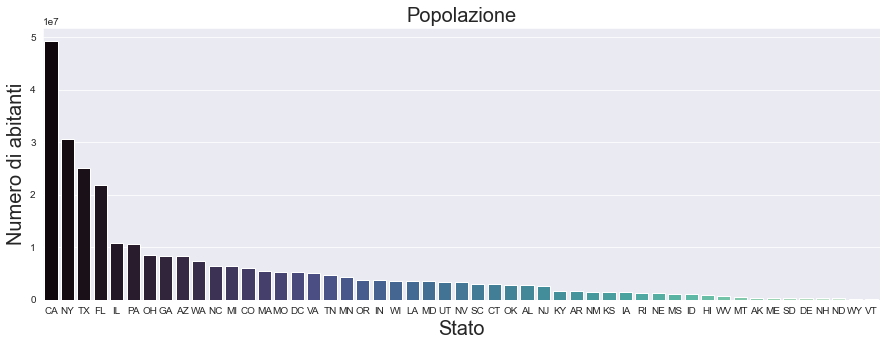

In [5]:
#Panoramica popolazione USA

#Selezione per stato della popolazione
a= info.groupby("state").sum().sort_values(by="population", ascending=False).reset_index()

#Visualizzo
g= sns.barplot(x=a.state, y=a.population, palette= 'mako');
g.figure.set_size_inches(15,5)
g.axes.set_title('Popolazione', fontsize=20)
g.set_xlabel('Stato', size= 20)
g.set_ylabel('Numero di abitanti', size= 20);

Così come anche il più alto numero di poveri risiede principalmente negli stati sopra citati.

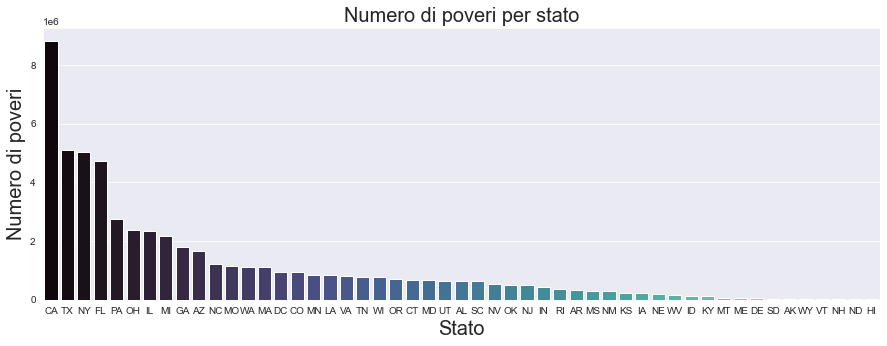

In [6]:
#Numero di poveri per stato

poor_by_state=info.groupby("state").pop_poor.sum().reset_index().sort_values(by="pop_poor", ascending=False)

#Visualizzo
g= sns.barplot(x=poor_by_state.state, y=poor_by_state.pop_poor, palette= 'mako');
g.figure.set_size_inches(15,5)
g.axes.set_title('Numero di poveri per stato', fontsize=20)
g.set_xlabel('Stato', size= 20)
g.set_ylabel('Numero di poveri', size= 20);

Tuttavia se ponderiamo il numero di poveri totale in base alla popolazione per stato, notiamo che le città con il tasso povertà/popolazione più alto sono altre rispetto a quelle rilevate prima, pertanto gli stati con un tasso di povertà più elevato li vediamo nel grafico immediatamente sotto.

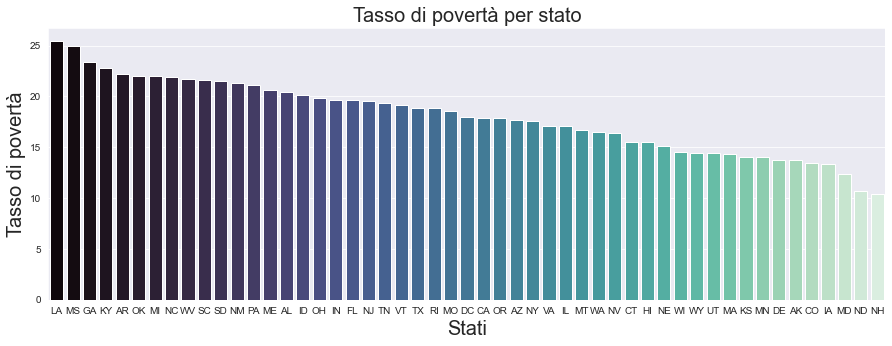

In [7]:
#Tasso di povertà per stato

ratepovertybystate = info[info['poverty_rate'].notna()]

list_state = list(ratepovertybystate['state'].unique())
ratepovbystate = []
for i in list_state:
    x = ratepovertybystate[ratepovertybystate['state']==i]
    ratepovbystate.append(sum(x.poverty_rate)/len(x))
f,ax = plt.subplots(figsize = (15,9))

ratepoverty_state = pd.DataFrame()
ratepoverty_state['list_state']  = list_state
ratepoverty_state['ratepovbystate'] = ratepovbystate
ratepoverty_state = ratepoverty_state.sort_values(by="ratepovbystate", ascending=False)

#Visualizzo
g= sns.barplot(x=ratepoverty_state.list_state, y=ratepoverty_state.ratepovbystate, palette= 'mako');
g.figure.set_size_inches(15,5)
g.axes.set_title('Tasso di povertà per stato', fontsize=20)
g.set_xlabel('Stati', size= 20)
g.set_ylabel('Tasso di povertà', size= 20);

Nel grafico seguente invece possiamo vedere quali sono gli stati aventi un tasso di completamento della scuola superiore maggiore.

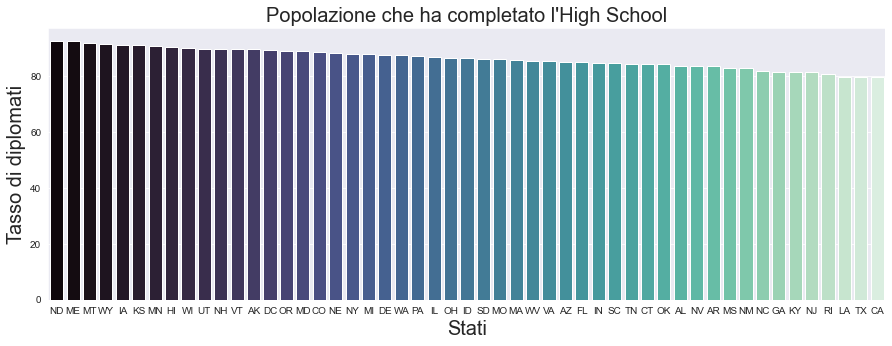

In [8]:
#Popolazione che ha completato l'High School

popinfograduated = info[info['percent_completed_hs'].notna()]

list_state = list(popinfograduated['state'].unique())
rategradbystate = []
for i in list_state:
    x = popinfograduated[popinfograduated['state']==i]
    rategradbystate.append(sum(x.percent_completed_hs)/len(x))

ratecomplet_state = pd.DataFrame()
ratecomplet_state['list_state']  = list_state
ratecomplet_state['rategradbystate'] = rategradbystate
ratecomplet_state = ratecomplet_state.sort_values(by="rategradbystate", ascending=False)

#Visualizzo
g= sns.barplot(x=ratecomplet_state.list_state, y=ratecomplet_state.rategradbystate, palette= 'mako');
g.figure.set_size_inches(15,5)
g.axes.set_title("Popolazione che ha completato l'High School", fontsize=20)
g.set_xlabel('Stati', size= 20)
g.set_ylabel('Tasso di diplomati', size= 20);

In questa grafica possiamo vedere come è distrubuita stato per stato la popolazione in base alla razza

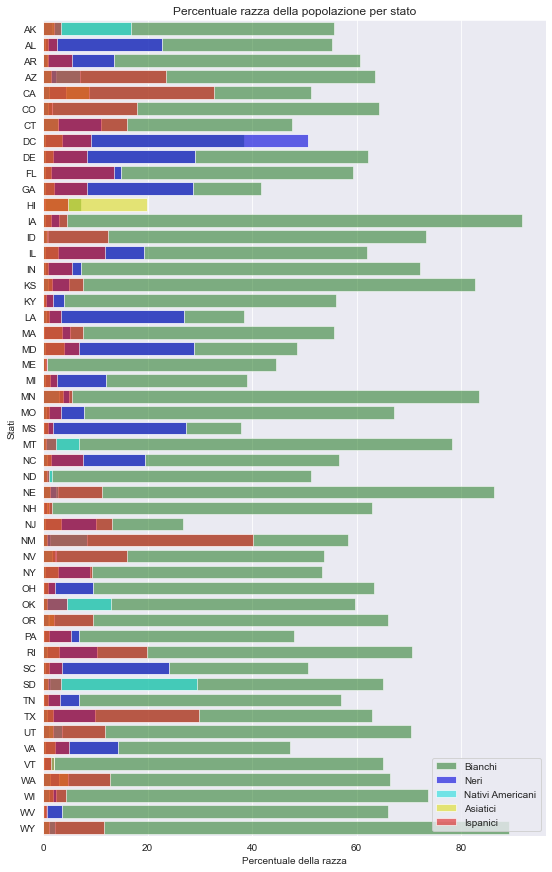

In [9]:
#Percentuale razza della popolazione per stato

info3.loc[:,['share_white','share_black','share_native_american','share_asian','share_hispanic']] = info3.loc[:,['share_white','share_black','share_native_american','share_asian','share_hispanic']].astype(float)
area_list = list(info3['state'].unique())
share_white = []
share_black = []
share_native_american = []
share_asian = []
share_hispanic = []
for i in area_list:
    x = info3[info3['state']==i]
    share_white.append(sum(x.share_white)/len(x))
    share_black.append(sum(x.share_black) / len(x))
    share_native_american.append(sum(x.share_native_american) / len(x))
    share_asian.append(sum(x.share_asian) / len(x))
    share_hispanic.append(sum(x.share_hispanic) / len(x))

#Visualizzo
f,ax = plt.subplots(figsize = (9,15))
sns.barplot(x=share_white,y=area_list,color='green',alpha = 0.5,label='Bianchi')
sns.barplot(x=share_black,y=area_list,color='blue',alpha = 0.7,label='Neri')
sns.barplot(x=share_native_american,y=area_list,color='cyan',alpha = 0.6,label='Nativi Americani')
sns.barplot(x=share_asian,y=area_list,color='yellow',alpha = 0.6,label='Asiatici')
sns.barplot(x=share_hispanic,y=area_list,color='red',alpha = 0.6,label='Ispanici')
ax.legend(loc='lower right',frameon = True)
ax.set(xlabel='Percentuale della razza', ylabel='Stati',title = "Percentuale razza della popolazione per stato")
plt.show()

### 2. Analisi uccisioni da parte della Polizia ai danni dei civili, moventi ed età delle vittime <a class="anchor" id="section_3_2"></a>

In questa sezione ci occuperemo di analizzare il numero di uccisioni rilevando le zone più colpite, l'età delle vittime e i fattori che hanno contribuito al compimento dell'atto da parte della Polizia.
Nel primo grafico possiamo vedere ancora una volta che, proporzionalmente alla popolazione il numero di vittime maggiore si trova in California, seguito dal Texas e la Florida.

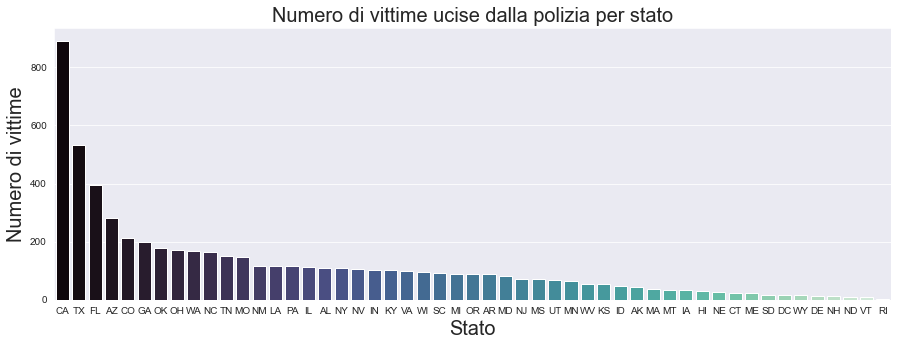

In [10]:
#Numero di vittime ucise dalla polizia per stato

#Per ogni stato conto il numero di vittime
a=info.groupby("state").sum().sort_values(by="cases",ascending = False).reset_index()

#Visualizzo
g= sns.barplot(x=a.state, y=a.cases, palette= 'mako');
g.figure.set_size_inches(15,5)
g.axes.set_title('Numero di vittime ucise dalla polizia per stato', fontsize=20)
g.set_xlabel('Stato', size= 20)
g.set_ylabel('Numero di vittime', size= 20);

Anche in questo caso rapportando le morti con il totale della popolazione per stato, la situazione cambia e notiamo che gli stati con un tasso di morte supriore sono, prendendo in esame solamente i primi tre: Alaska, Montana e New Mexico.

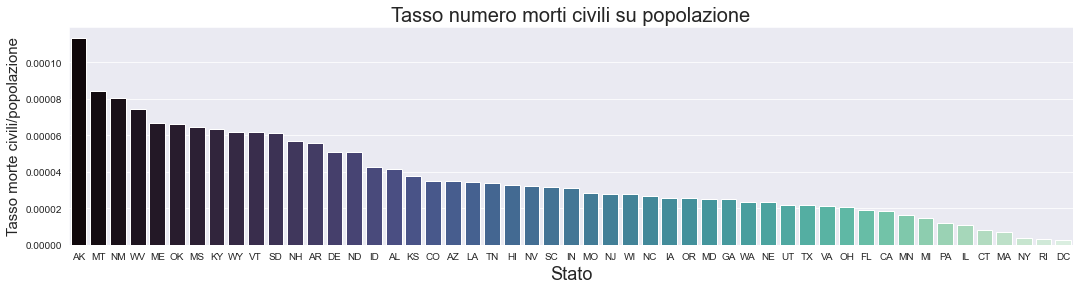

In [11]:
#Tasso numero morti civili su popolazione per stato

#Seleziono le vittime e la popolazione in base allo stato
k= kill.groupby("state")["id"].count().reset_index()
k2=population_by_city.groupby("state")["population"].sum().reset_index()
k3 = k.merge(k2, on="state", how="left")
k3.columns=["state", "kill", "pop"]
k3["kill_pop"]= k3["kill"]/k3["pop"]
k3=k3.sort_values(by="kill_pop", ascending=False)

#Visualizzo
g=sns.barplot(x='state', y='kill_pop', data=k3 ,palette= 'mako')
g.axes.set_title('Tasso numero morti civili su popolazione', fontsize=20)
g.set_xlabel('Stato', size=18)
g.set_ylabel('Tasso morte civili/popolazione', size= 15)
g.figure.set_size_inches(18,4)

Andando più nello specifico e analizzando città per città notiamo che le città più pericolose in assoluto possono essere riassunte nel grafico seguente. In particolare ne vediamo le 15 con il tasso di morti su popoplazione più alto consederando però solamente quelle aventi un numero di vittime pari o superiore a 25.

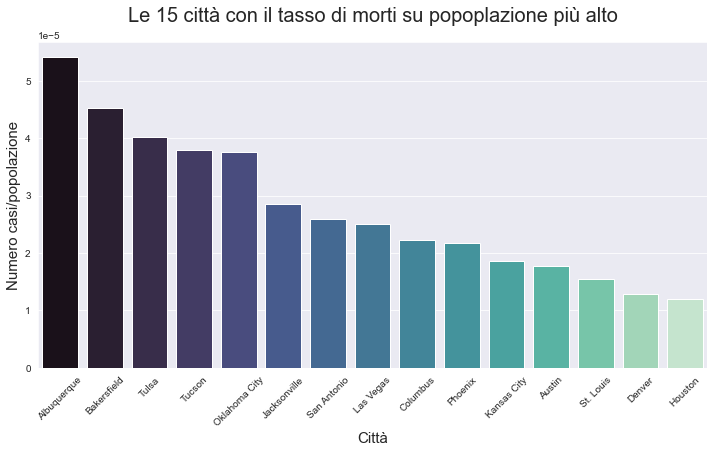

In [12]:
#Visualizzo le 15 città con il tasso morti per popolazione più alto

#Prelevo i casi per città superiori a 25 e ne visualizzo solo i primi 10
city=info[info['cases']>=25].sort_values(by=['tot_cases_population'],ascending=False)
city=city[:15]

#Visualizzo
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.barplot(x='city', y='tot_cases_population', data=city,palette= 'mako')
plt.xlabel('Città',size=15)
plt.ylabel('Numero casi/popolazione', size=15)
plt.title('Le 15 città con il tasso di morti su popoplazione più alto', pad=20, size=20);

Senza considerare la popolosità della città il record di uccisioni per città appartiene a Los Angeles.

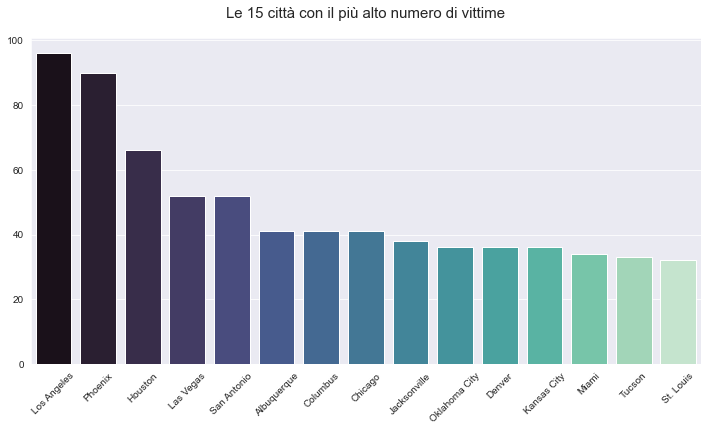

In [13]:
#Visualizzo le 15 città con il tasso di morti più alto in senso assoluto

city= kill.city.value_counts()

#Visualizzo
plt.figure(figsize=(12,6))
sns.barplot(x=city[:15].index, y=city[:15].values, palette="mako")
plt.xticks(rotation=45)
plt.title("Le 15 città con il più alto numero di vittime", pad=20,fontsize=15)
plt.show()

Avendo analizzato i singoli casi, assegnandogli un riferimento temporale potrebbero indicarci la presenza di un'eventuale ciclicità o ricorrenza che con il passare del tempo potrebbe ripetersi. Tuttavia non sempra questo il caso in quanto l'andamento mensile del numero di vittime sembra seguire un ordine di eventi che non ha un'identità precisa quindi non è possibile rilevare nessun aspetto importante. Notiamo però che verso marzo del 2018 c'è un calo importante nel numero delle vittime. Questo fatto purtroppo con i dati a nostra disposizione non ci consente di attribuirgli una spiegazione specifica. Situazione in parte diversa invece nel marzo 2020, dove anche in questo caso vediamo un calo drastico che molto probalilmente è scaturito dall'arrivo del Corona Virus, costringendo tanta gente a restare all'interno delle abitazioni con conseguente riduzione del numero di crimini in generale.

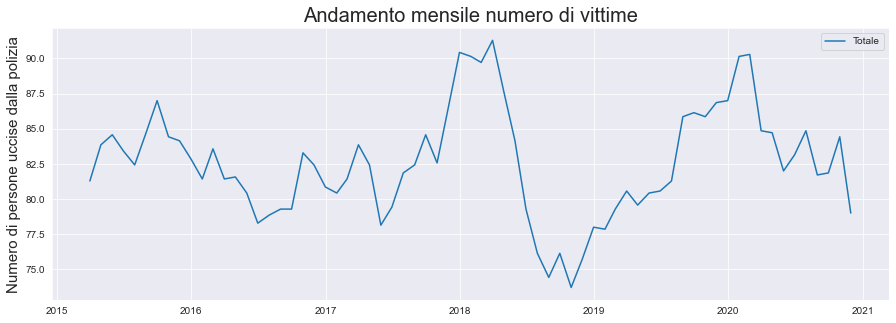

In [14]:
# Leggo il dataset del Washington Post e assegno come indice un indice temporale

kd=pd.read_csv('fatal-police-shootings-data.csv',parse_dates=True, index_col='date')

#Imposto resample mensile
kd_tot=kd.resample('M', label='left')['id'].count()

#Creo una media mobile a 7 giorni 
kd_tot_mean=kd_tot.rolling(7,center=True, min_periods=7).mean()

#Visualizzo
plt.figure(figsize=(15,5))
plt.plot(kd_tot_mean, label='Totale')
plt.title('Andamento mensile numero di vittime',size= 20)
plt.ylabel('Numero di persone uccise dalla polizia', size=15)
plt.legend();

#notare aspetto covid

In maniera molto carina, attraverso una mappa è possibile vedere la localizzazione degli stati con il più alto numero di uccisioni da parte della Polizia ai danni dei civili.

In [15]:
#Panoramica casi totali per ogni stato
usamapcases= pd.DataFrame({"state" : kill.state.value_counts().index, "cases": list(kill.state.value_counts())})

fig = px.choropleth(usamapcases, locations='state', locationmode='USA-states', color='cases',
                           range_color=(usamapcases.cases.min(),usamapcases.cases.max()),
                           scope="usa",
                           color_continuous_scale='blues',
                           title='antani'
                          )
fig.update_layout(title='Casi totali per stato in USA', title_x=0.5)

In questa mappa invece ci focalizziamo sulle città e con una grafica molto carina e chiara nel punti rossi vengono ne vengono messe in risalto quelle con un alto numero di uccisioni. Notiamo che come rilevato anche sopra il numero maggiore di vittime colpisce la Califonia.

In [16]:
#Panoramica uccisioni in base alla città

fig = go.Figure(data=go.Scattergeo(
        lon = info['lng'],
        lat = info['lat'],
        text = info['city'] + ', ' + info['state'] + ': ' + info['cases'].astype(str) ,
        mode = 'markers',
        marker = dict(
            size = info['cases'].apply(lambda x: 4 if x < 5 else x).dropna(),
            opacity = 0.8,
            symbol = 'circle',
            colorscale = 'bluered_r',
            reversescale = True,
            cmin = 1,
            color = info['cases'],
            cmax = info['cases'].max(),
            colorbar_title="Casi dal 2015 al 2021"
        )))

fig.update_layout(
        margin={"r":0,"t":30,"l":0,"b":0},
        title = 'Uccisioni della polizia per città in USA dal 2015 al 2021',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = False,
            landcolor = "blue",
            subunitcolor = "blue",
            countrycolor = "blue",
            subunitwidth = 0.5
        )
    )
fig.update_layout(title_x=0.5)
fig.show()

Addentrandoci solamente dentro lo stato della California, ne possiamo vedere le città e le aree più colpite.

In [17]:
#Analizziamo il caso specifico: California
info_ca = info[info.state == 'CA']

fig = go.Figure(data=go.Scattergeo(
        lon = info_ca['lng'],
        lat = info_ca['lat'],
        text = info_ca['city'] + ': ' + info_ca['cases'].astype(str),
        mode = 'markers',
        marker = dict(
            size = info_ca['cases'].apply(lambda x: 4 if x < 5 else x).dropna(),
            opacity = 0.8,
            symbol = 'circle',
            colorscale = 'bluered_r',
            reversescale = True,
            cmin = 1,
            color = info_ca['cases'],
            cmax = info_ca['cases'].max(),
            colorbar_title="Casi dal 2015 al 2021"
        )))

fig.update_layout(
        margin={"r":0,"t":30,"l":0,"b":0},
        title = 'Uccisioni della polizia in California dal 2015 al 2021',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = False,
            landcolor = "blue",
            subunitcolor = "blue",
            countrycolor = "blue",
            subunitwidth = 0.5,
            center = dict(lat = 36.778259, lon = -121.417931),
            projection_scale = 2.3
        )
    )
fig.show()

Il movente che ha spinto il poliziotto a ricorrere ad un metodo di risoluzione così drastico potrebbe essere in parte dovuto a ciò che è illustrato nel grafico seguente. Infatti la maggior parte delle vittime aveva con sè un'arma che potrebbe aver spaventato la forza armata e costretto esso a procedere in maniera definifiva.

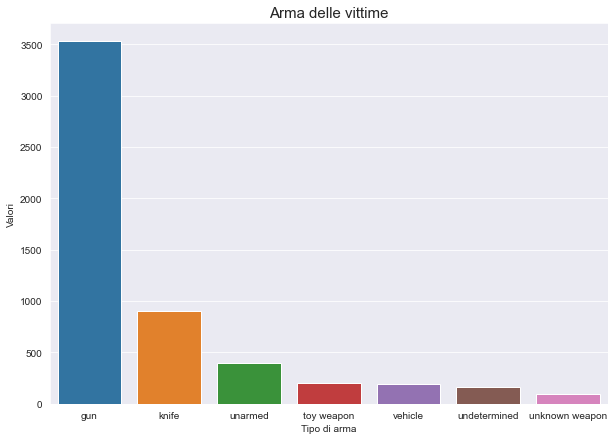

In [18]:
#Arma delle vittime
armed = kill.armed.value_counts()

#Visualizzo
plt.figure(figsize=(10,7))
sns.barplot(x=armed[:7].index,y=armed[:7].values)
plt.ylabel('Valori')
plt.xlabel('Tipo di arma')
plt.title('Arma delle vittime',fontsize=15)
plt.show()

A conferma di ciò possiamo anche notare che la polizia ha agito a seguito di un attacco nella maggioranza dei casi.

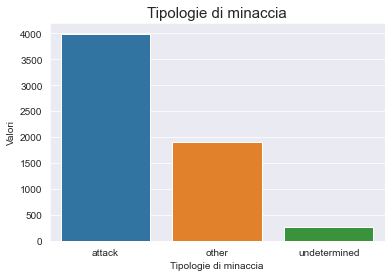

In [19]:
#Tipologie di minaccia
sns.countplot(kill.threat_level)
plt.xlabel('Tipologie di minaccia')
plt.ylabel('Valori')
plt.title('Tipologie di minaccia', fontsize = 15)
plt.show()

In questo grafico invece possiamo vedere che una gran parte delle vittime non soffriva di disturbi mentali.

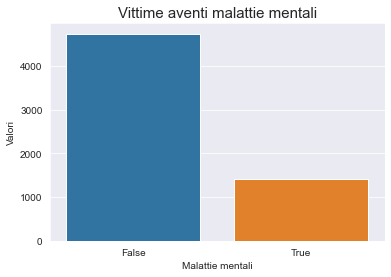

In [20]:
#Vittime aventi malattie mentali
sns.countplot(kill.signs_of_mental_illness)
plt.xlabel('Malattie mentali')
plt.ylabel('Valori')
plt.title('Vittime aventi malattie mentali', fontsize = 15)
plt.show()

Interessante in questa grafica invece vedere che quasi la totalità delle vittime era di sesso maschile.

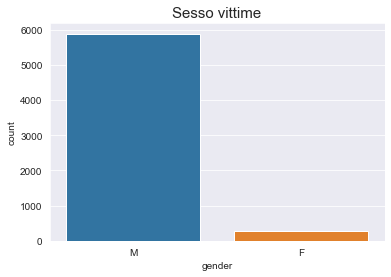

In [21]:
#Sesso vittime
sns.countplot(kill.gender)
plt.title("Sesso vittime",fontsize=15)
plt.show()

Analizzando per fascie d'età il numero delle vittime da questa grafica vediamo che la maggior parte delle vittime aveva un'età compresa tra i 30-35 anni, seguita dalla fascia 25-30 e 18-25.

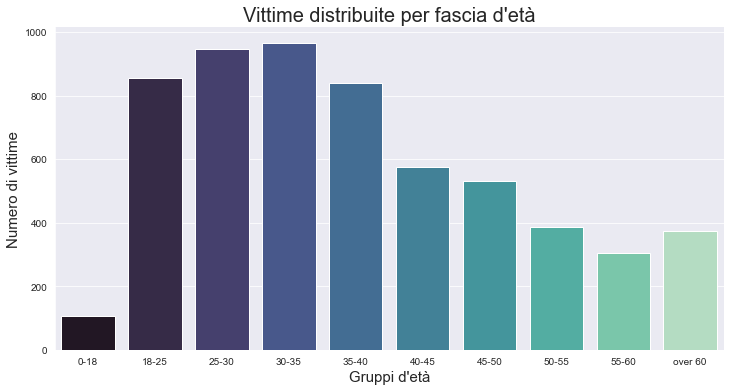

In [22]:
#Individuo delle fasce d'età e assegno le labels
bins=[0,18,25,30,35,40,45,50,55,60,150]
labels=['0-18','18-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60','over 60']

# Divido il gruppo in fasce d'età
kill['AgeGroup']= pd.cut(kill['age'], bins=bins, labels=labels, right=False)
kill['AgeGroup'].value_counts()

#Visualizzo
sns.catplot(x='AgeGroup',kind='count', data=kill, palette='mako',aspect=2)
plt.title("Vittime distribuite per fascia d'età", fontsize=20);
plt.xlabel("Gruppi d'età", size= 15)
plt.ylabel("Numero di vittime", size = 15);

### 3. Rilevamento eventuale presenza di forme di razzismo nei casi di omicio da parte della Polizia  <a class="anchor" id="section_3_3"></a>

Un aspetto importantissimo da valutare nei dati in nostro possesso è quello di verificare se le forze armate adottano un comportamento diverso a seconda della persona che si trovano davanti. In particolare facciamo riferimento al loro colore della pelle e quindi la loro razza.
Attraverso la grafica seguente notiamo che in senso assoluto il numero di vittime di persone bianche appare in maniera doppiamente superiore a quella dei casi in cui la razza è nera. Confrontando anche le altre etnie questa differenza è ancora  più marcata.


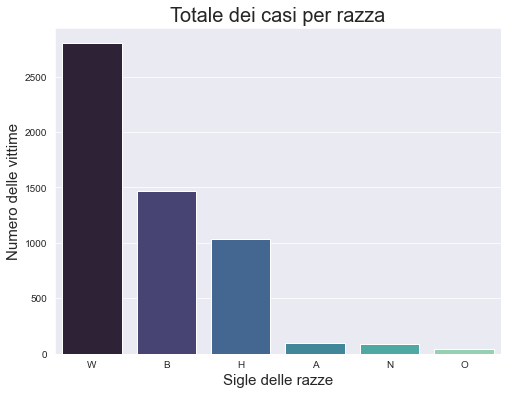

In [23]:
#Numero totale delle vittime per razza

#Conto le occorrenze delle razze
kill_by_race = kill.race.value_counts()

#Visualizzo
f, ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(x=kill_by_race.index, y= kill_by_race.values, palette="mako")
ax.set_title('Totale dei casi per razza',size= 20)
plt.xlabel('Sigle delle razze',size=15)
plt.ylabel('Numero delle vittime',size=15);

Tuttavia ponderando il numero delle vittime divise per razza con la loro rispettiva distribuzione demografica, notiamo che quanto rilevato prima è poco significativo, in quanto ciò è dovuto alla grande superiorità di persone di etnia bianca. Quindi rapportato alla popolazione rileviamo nel grafico seguente che il numero di uccisioni di razza nera da parte della Polizia Americana è superiore, confermando un tasso di condizionamento raziale verso la popolazione nera.

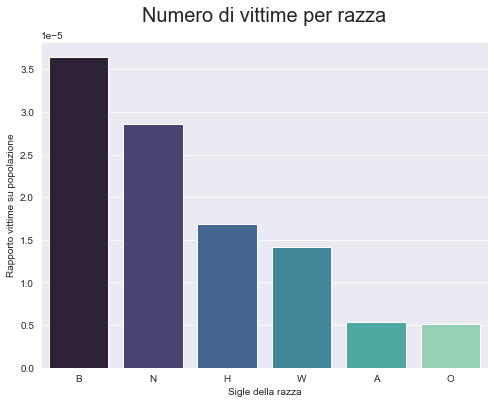

In [24]:
#Creo un dataframe in cui inserisco il numero di persone per razza negli USA
#FONTE: https://www.census.gov/content/dam/Census/library/publications/2020/demo/p25-1144.pdf

pop_by_race=pd.Series([198330000,40260000,61050000,18480000,2970000, 9240000], index=['W','B','H','A','N','O'])

#Creo le colonne di dati che voglio rappresentare nel grafico
kill_on_pop=kill_by_race/pop_by_race
kill_on_pop=kill_on_pop.sort_values(ascending=False)

#Visualizzo
f, ax = plt.subplots(1,1, figsize=(8,6))
sns.barplot(x= kill_on_pop.index, y= kill_on_pop.values, palette='mako')
ax.set_title('Numero di vittime per razza',size= 20, pad=20)
plt.xlabel('Sigle della razza')
plt.ylabel('Rapporto vittime su popolazione');

Analizzando un'andamento temporale di quanto descritto sopra notiamo nel grafico seguente che la tendenza del numero di uccisioni di persone aventi razza bianca è significativamente diminuito dall'ultimo anno. Stessa tendenza la notiamo nelle persone con un etnia nera o ispanica, anche se in maniera molto ridotta.

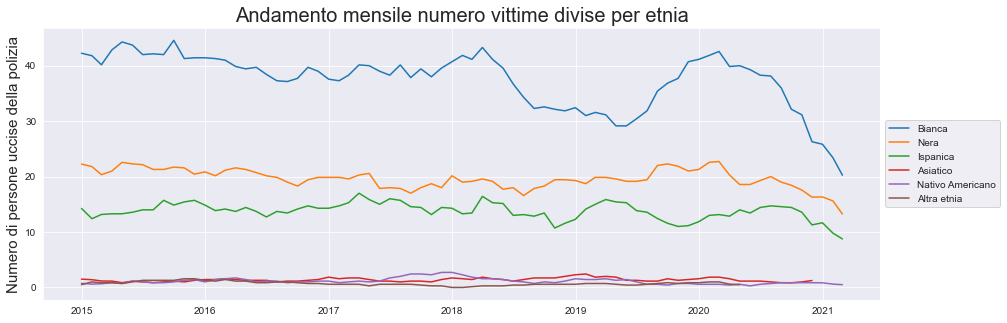

In [25]:
#Andamento mensile del numero delle vittime divise per razza

# Raggruppo i dati mensilmente per razza
kd_white=kd[kd['race']=='W'].resample('M', label='left')['id'].count()
kd_black=kd[kd['race']=='B'].resample('M', label='left')['id'].count()
kd_hispanic=kd[kd['race']=='H'].resample('M', label='left')['id'].count()
kd_asian=kd[kd['race']=='A'].resample('M', label='left')['id'].count()
kd_native=kd[kd['race']=='N'].resample('M', label='left')['id'].count()
kd_other=kd[kd['race']=='O'].resample('M', label='left')['id'].count()

# Uso la funzione rolling per avere escursioni meno ampie
kd_white=kd_white.rolling(7,center=True, min_periods=3).mean()
kd_black=kd_black.rolling(7,center=True, min_periods=3).mean()
kd_hispanic=kd_hispanic.rolling(7,center=True, min_periods=3).mean()
kd_asian=kd_asian.rolling(7,center=True, min_periods=3).mean()
kd_native=kd_native.rolling(7,center=True, min_periods=3).mean()
kd_other=kd_other.rolling(7,center=True, min_periods=3).mean()

#Visualizzo
plt.figure(figsize=(15,5))
plt.plot(kd_white, label='Bianca')
plt.plot(kd_black, label='Nera')
plt.plot(kd_hispanic, label='Ispanica')
plt.plot(kd_asian, label= 'Asiatico')
plt.plot(kd_native, label='Nativo Americano')
plt.plot(kd_other,label='Altra etnia')
plt.title('Andamento mensile numero vittime divise per etnia',size= 20)
plt.ylabel('Numero di persone uccise della polizia',size=15)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Nella mappa geografica seguente possiamo identificare quali sono gli stati aventi un tasso di uccisioni ponderato alla popolazione maggiore. Notiamo come il North Dakota in particolare, ma anche il South Dakota, il Montana e il	Wyoming dominano e risultano gli stati con un maggior tasso di mortalità per mano della Polizia.

In [26]:
#Percentuale di uccisioni razza nera per ogni stato
black_kill= info3.groupby("state")["b_cases"].sum()
total_kill= kill.groupby("state")["id"].count()
ratekill_black = black_kill / total_kill * 100
ratekill_black = ratekill_black.reset_index()
ratekill_black.columns=["state", "kill_black_rate"]

fig = px.choropleth(ratekill_black, locations='state', locationmode='USA-states', color='kill_black_rate',
                           range_color=(ratekill_black.kill_black_rate.min(),ratekill_black.kill_black_rate.max()),
                           scope="usa",color_continuous_scale='blues', title='Tasso di uccioni razza nera per stato')

fig.update_layout(title_x = 0.5)
fig.show()

In questa grafica possiamo avere una panoramica razza per razza dell'età in fasce del numero di vittime. Ad incidere particolarmente sulla fascia 30-35, come rilevato in precedenza, sono i le vittime di razza bianca

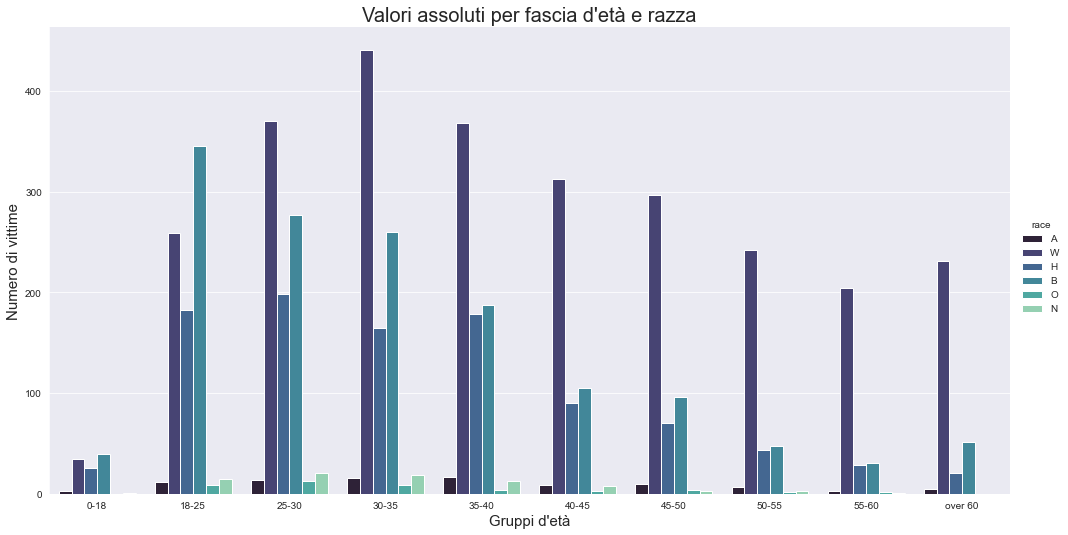

In [27]:
#Valori assoluti per fascia d'età e razza
sns.catplot(x='AgeGroup',kind='count',hue='race', data=kill, palette='mako',aspect=2, height=7)
plt.title("Valori assoluti per fascia d'età e razza", fontsize=20);
plt.xlabel("Gruppi d'età", size= 15)
plt.ylabel("Numero di vittime", size = 15);

Nella distribuzione seguente delle vittime per età, notiamo come a ridosso di età molto giovane e molto ansiana c'è una netta predominanza per uccisioni di razza bianca

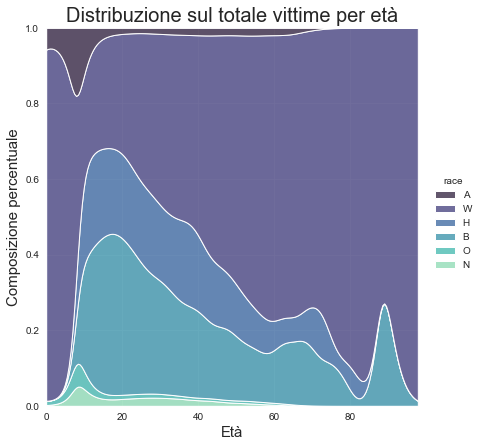

In [28]:
#Distribuzione per età sul totale delle vittimme
sns.displot(data=kill, x="age", hue="race", kind="kde", height=6, multiple="fill", clip=(0, None), palette="mako")
plt.title("Distribuzione sul totale vittime per età", fontsize=20);
plt.xlabel("Età", size= 15)
plt.ylabel("Composizione percentuale", size = 15);

### 4. Analisi sociale, fattori che potrebbero incidere sul tasso di uccisioni da parte della Polizia Americana <a class="anchor" id="section_3_4"></a>

In questa sezione ci soffermeremo sui fattori come l'istruzione e il tasso di povertà per vedere se questi aspetti socio-economici possono incidere in qualche maniera anche sul numero delle vittime.
Per prima cosa attraverso una Heatmap possiamo avere una visione su quelle che potrebbero essere le correlazioni maggiorni sulle variabili in nostro possesso. In particolare possiamo osservare come la correlazione maggiore, come era facile intuire, la troviamo nelle variabili che ci descrivono il tasso di povertà e il reddito medio delle famiglie. Siccome risulta negativo, all'aumentare di uno, l'altro diminuisce. 

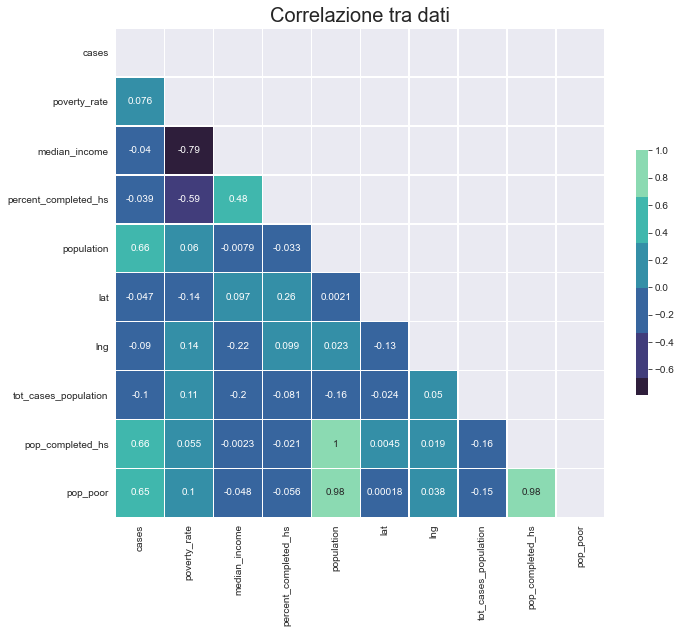

In [29]:
#Heatmap per studiare la correlazione tra variabili

#Visualizzo
corr= info[info['population']>=5000].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap=sns.color_palette("mako")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True,annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlazione tra dati', size=20);

Aspetto interessante da analizzare riguarda il mettere a confronto il tasso di completamento della scuola superiore con il tasso di povertà. Nel grafico seguente notiamo come in maniera abbastanza marcata, all'aumentare del tasso di povertà, diminuisce il tasso di completamento dell' High School.

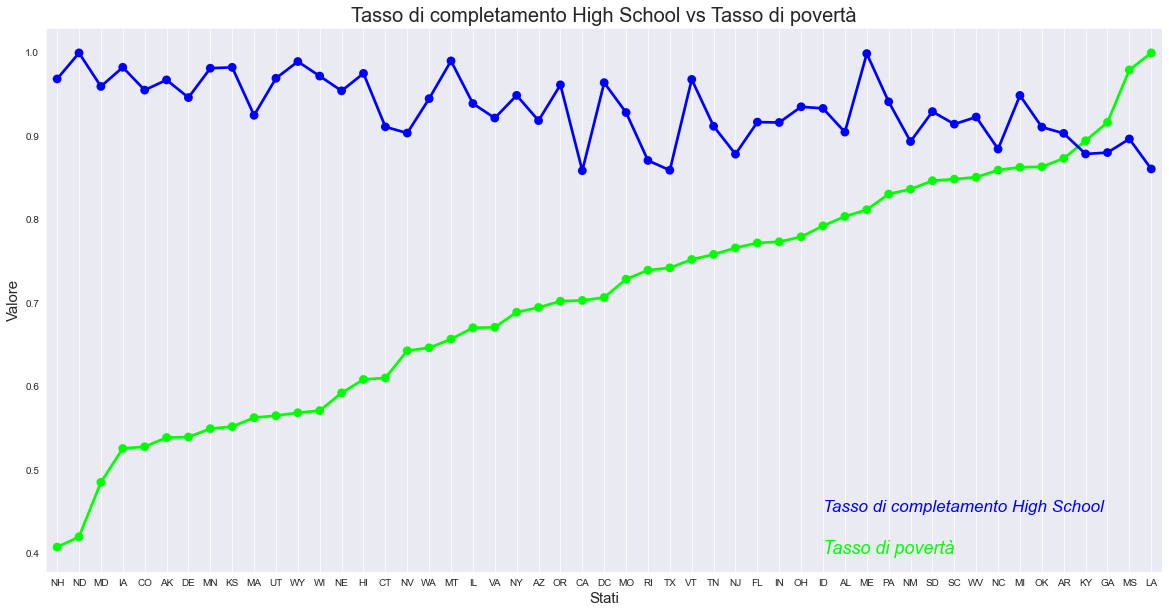

In [30]:
#Tasso di completamento High School vs Tasso di povertà
df = ratepoverty_state.merge(ratecomplet_state)
df["area_poverty_ratio"] = df["ratepovbystate"]/max(df["ratepovbystate"])
df["area_highschool_ratio"] =df["rategradbystate"]/max(df["rategradbystate"])
df = df.sort_values(by="area_poverty_ratio")

#Visualizzo
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x=df.list_state,y=df.area_poverty_ratio,color='lime',alpha=0.8)
sns.pointplot(x=df.list_state,y=df.area_highschool_ratio,color='blue',alpha=0.8)
plt.text(35,0.45,'Tasso di completamento High School',color='blue',fontsize = 17,style = 'italic')
plt.text(35,0.4,'Tasso di povertà',color='lime',fontsize = 18,style = 'italic')
plt.xlabel('Stati',fontsize = 15)
plt.ylabel('Valore',fontsize = 15)
plt.title('Tasso di completamento High School vs Tasso di povertà',fontsize = 20)
plt.grid()

Notiamo questo comportamento in maniera più chiara attraverso questa distribuzione servendosi di un Jointplot. La concentrazione maggiore l'abbiamo nella fascia di povertà che si aggira tra il 5% e il 20%.

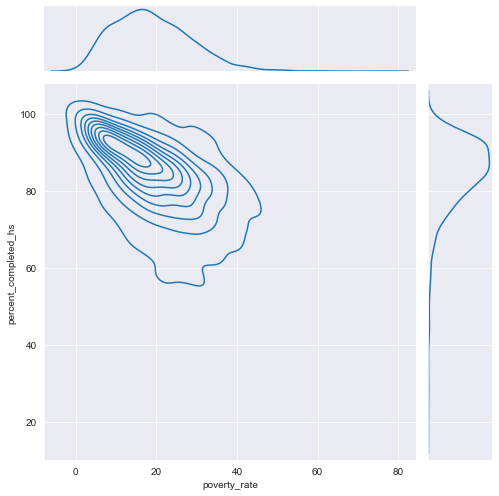

In [31]:
#Distribuzione tasso di povertà - percentuale di completamento High School
g= sns.jointplot(info.poverty_rate, info.percent_completed_hs, kind="kde", size=7)
plt.show()

Avendo studiato in generale alcuni degli aspetti socio-economici nei grafici sopracitati, andiamo ora a vedere se essi possono incidere sul numero di vittime causate della Polizia.
Notiamo nel grafico seguente come c'è una correlazione positiva, seppur molto debole, tra le vittime e il tasso di povertà. Infatti all'aumentare di quest'ultima, notiamo un innalzamento nel numero delle vittime. Tuttavia la quasi totalità dei casi sono avvenuti in città con un basso tasso di povertà.

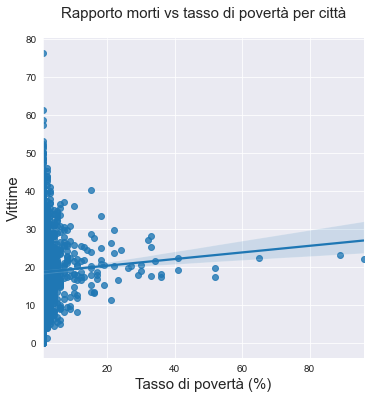

In [32]:
#Correlazione tasso di povertà - vittime

#Visualizzo
f=sns.lmplot(y='poverty_rate', x='cases', data=info)
plt.title('Rapporto morti vs tasso di povertà per città',pad=20, size=15)
plt.xlabel('Tasso di povertà (%)', size= 15)
plt.ylabel('Vittime', size= 15);

Uguale considerazione può essere fatta se le vittime sono ponderate alla popolazione.

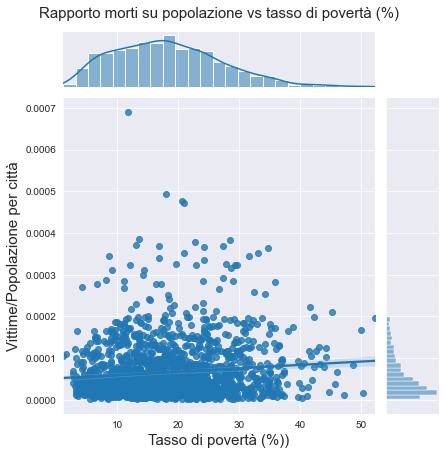

In [33]:
#Correlazione tasso di povertà - vittime ponderate alla popolazione

#Visualizzo
sns.jointplot( x='poverty_rate',y='tot_cases_population', data=info[info['population']>=5000], kind='reg')
plt.title('Rapporto morti su popolazione vs tasso di povertà (%)',pad=80, size=15)
plt.xlabel('Tasso di povertà (%))', size= 15)
plt.ylabel('Vittime/Popolazione per città', size= 15);

Particolare rilevanta possiamo attribuirla osservando questo grafico in quanto ci illustra una correlazione negativa abbastanza significativa sulle vittime ponderate alla popolazione confrontate al reddito medio delle famiglie. Con il diminuire di quest'ultimo segue un aumento delle vittime. Inoltre la quasi totalità dei casi si aggira su livelli di reddito bassi rispetto alla popolazione complessiva.
Per la distribuzione sono state selezionate le città aventi una popolazione minima di 5000 abitanti.

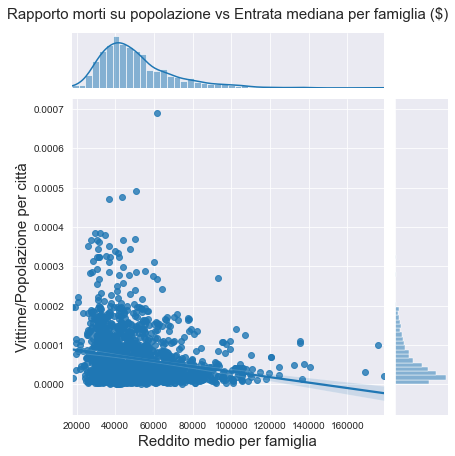

In [34]:
#Correlazione reddito medio - vittime ponderate alla popolazione

#Visualizzo
k=sns.jointplot(y='tot_cases_population', x='median_income', data=info[info['population']>=5000],kind='reg')
plt.title('Rapporto morti su popolazione vs Entrata mediana per famiglia ($)',pad=80, size=15)
plt.xlabel('Reddito medio per famiglia', size= 15)
plt.ylabel('Vittime/Popolazione per città', size= 15);

Alla stessa maniera è possibile attribuire un collagamento tra le vittime e il completamento degli studi delle scuole superiori. Ciò è possibile affermarlo in quanto osservando la distibuzione seguente notiamo come, seppur in maniera abbastanza debole, all'aumentare del tasso di completamento delle superiori, il numero delle vittime ponderate alla popolazione per città scende.
Per la distribuzione sono state selezionate le città aventi una popolazione minima di 5000 abitanti.

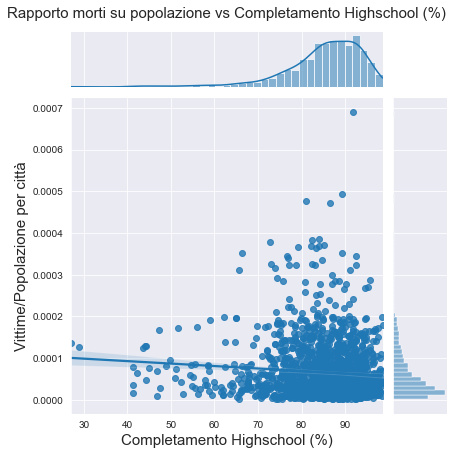

In [35]:
#Correlazione tasso di completamento High School - vittime ponderate alla popolazione

#Visualizzo
l=sns.jointplot(y='tot_cases_population', x='percent_completed_hs', data=info[info['population']>=5000], kind='reg')
plt.title('Rapporto morti su popolazione vs Completamento Highschool (%)',pad=80, size =15)
plt.xlabel('Completamento Highschool (%)', size= 15)
plt.ylabel('Vittime/Popolazione per città', size= 15);

## Conclusioni <a class="anchor" id="chapter4"></a>

Dall'analisi condotta possiamo quindi trarne alcune conclusioni: Iniziando da una panoramica generale sulla conformazione demografica della popolazione abbiamo rilevato che lo stato più popoloso degli Stati Uniti d'America è la California, seguita da New York e dal Texas. Gli stati più poveri in relazione alla popolazione sono Louisiana, Mississippi e la Georgia, mentre quelli con un tasso di completamento delle scuole superiore maggiore North Dakota, Maine, Montana.

Il numero maggiore di vittime causate dalle forze armate americane sono state rilevate negli stati della California, Texas e Florida, ma in relazione alla popolazione i stati più pericolosi sono: Alaska, Montana e New Mexico.
Una delle cause che potrebbe aver mosso la Polizia a compiere questi atti potrebbe essere il fatto che più della metà delle vittime era in possesso di un'arma da fuoco, oppure un altro oggetto pericoloso. Inoltre la quasi totalità delle vittime è di sesso maschile con una età compresa tra i 20 e i 35 anni. 

Osservando l'andamento temporale degli omicidi non abbiamo rilevato nessuna ciclicità. Gli unici aspetti rilevanti riguardano dei cali importanti nel periodo di marzo 2018 che non riusciamo però a dargli una spiegazione, mentre stessa situazione la ritroviamo nel marzo 2021 dove in questo caso possiamo presumibilmente ricondurlo all'arrivo del Corona Virus.

Analizzando i casi di omicidio divisi per razza abbiamo rilevato dei condizionamenti che riportano a pregiudizi raziali. Infatti seppur il numero massimo di vittime fa riferimento a persone biance, se rapportiamo il numero di vittime con il totale della popolazione di quella specifica etnia notiamo che in prima posizione troviamo persone di etnia nera, seguita da persone bianche e ispaniche.

Prendendo in considerazione alcuni aspetti socio-economici siamo stati in grado di attribuire correlazioni con il numero di vittime commesse dalle forze armate. In particolare abbiamo rilevato che, anche se sensibilimente, il numero delle vittime aumenta all'aumentare del tasso di povertà, anche se però la quasi totalità degli omicidi sono stati commessi in città con un tasso di povertà basso. Situazione analoga la ritroviamo se confrontiamo il numero delle vittime per popolazione con il tasso di completamento delle scuole superiori. Da esse possiamo riscontrare una correlazione debole, ma presente, infatti all'aumentare del livello di scolarizzazione il numero di omicidi diminuisce.